In [142]:
# ============================================================================
# BASELINE MODELING - Decision Tree (No Feature Engineering)
# ============================================================================

# Purpose: Get a baseline performance metric before feature engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [143]:
# ============================================================================
# STEP 1: Load Preprocessed Data
# ============================================================================

# Load the model-ready dataset , 124,097 matches)
df = pd.read_csv('../data/processed/matches_with_engineered_features.csv')

print(f"✓ Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist()[:20], "...")  # Show first 20 columns
print(f"\nTarget variable distribution:")
print(df['player1_won'].value_counts())
print(f"\nMissing values: {df.isnull().sum().sum()}")

# print all column names
print(df.columns.tolist())
df.tail(100).to_csv('df_tail.csv', index=False)


✓ Data loaded successfully!
Shape: (161807, 124)

Columns (124):
['player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'player1_won', 'draw_size', 'tourney_date', 'best_of', 'Qualifying_match', 'player1_hand_L', 'player1_hand_R', 'player1_hand_U', 'player2_hand_L', 'player2_hand_R', 'player2_hand_U', 'player1_entry_2) A'] ...

Target variable distribution:
player1_won
1    81188
0    80619
Name: count, dtype: int64

Missing values: 0
['player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'player1_won', 'draw_size', 'tourney_date', 'best_of', 'Qualifying_match', 'player1_hand_L', 'player1_hand_R', 'player1_hand_U', 'player2_hand_L', 'player2_hand_R', 'player2_hand_U', 'player1_entry_2) A', 'player1_entry_3)', 'player1_entry_5) A', 'player1_entry_6)', 'player1_entry_6) A', 'player1_entry_8)', 'player1_entry_A', 'player1_e

# Trying things to improve accuracy :
## 1. Deal with sparsity so only training on atp_matches and not qualifying matches since I believe those are more sparse:


DATASET SIZES
Full dataset:    161,807 matches
ATP-only:        42,356 matches
Qualifying:      119,451 matches

SPARSITY COMPARISON (% of Zeros)
                         Full_Dataset_Zero%  ATP_Only_Zero%  Improvement
h2h_matches                       69.017410       56.922278    12.095132
player2_hard_matches              47.996687       43.115497     4.881190
player1_hard_matches              48.005958       43.169799     4.836159
player2_grass_matches             94.798742       90.022665     4.776077
player1_grass_matches             94.772785       90.017943     4.754842
player1_clay_win_rate              1.259525        1.204080     0.055446
player2_clay_win_rate              1.268178        1.246577     0.021601
player1_recent_form                2.183465        2.245255    -0.061789
player1_career_win_rate            2.181611        2.245255    -0.063643
player2_recent_form                2.205714        2.278308    -0.072593
player2_career_win_rate            2.205096        

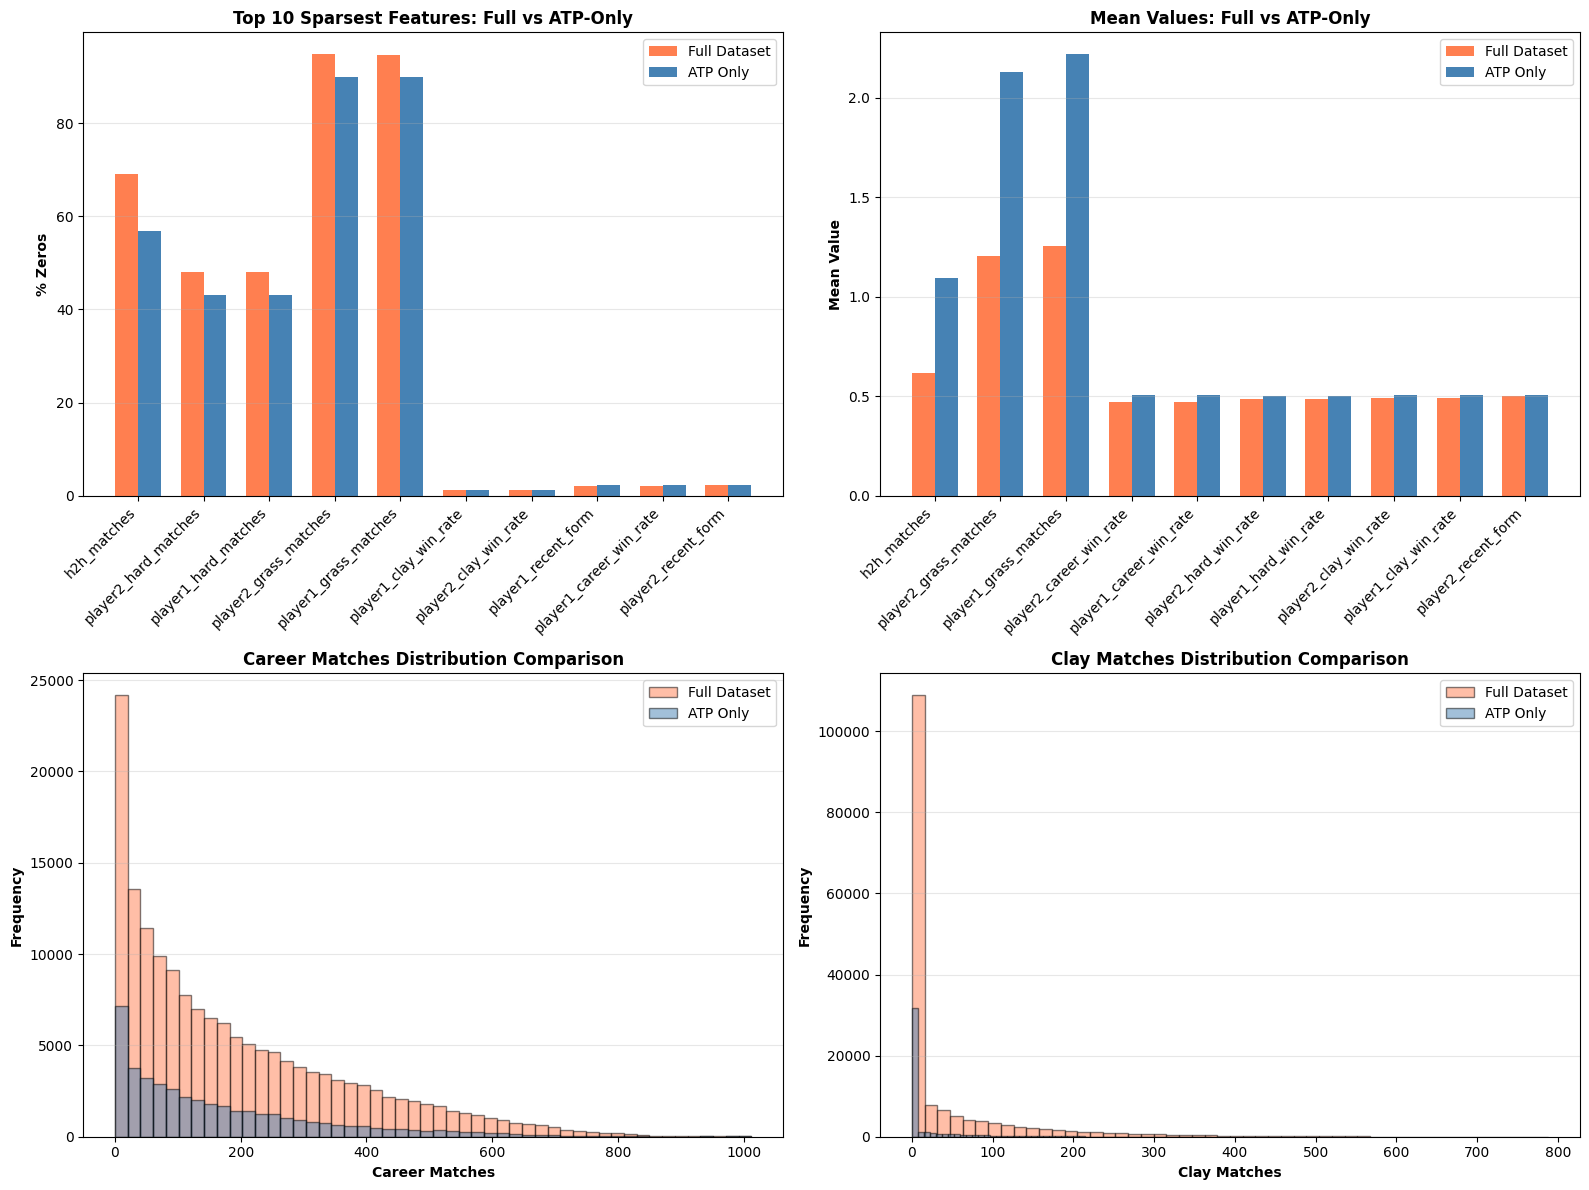


OVERALL SUMMARY
Average Sparsity (% zeros):
  Full Dataset: 24.57%
  ATP Only:     24.44%
  Improvement:  +0.13%

Average Completeness (% non-zeros):
  Full Dataset: 75.43%
  ATP Only:     75.56%
  Improvement:  +0.13%

Median Career Matches:
  Full Dataset: 136
  ATP Only:     115
  Increase:     -21


In [144]:


# ============================================================================
# SPARSITY COMPARISON: Full Dataset vs ATP-Only
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load both datasets
df_full = pd.read_csv('../data/processed/matches_with_engineered_features.csv')
df_atp = df_full[df_full['Qualifying_match'] == 0].copy()

print("="*70)
print("DATASET SIZES")
print("="*70)
print(f"Full dataset:    {len(df_full):,} matches")
print(f"ATP-only:        {len(df_atp):,} matches")
print(f"Qualifying:      {(df_full['Qualifying_match'] == 1).sum():,} matches")

# Select engineered features to analyze
engineered_features = [
    'player1_career_matches', 'player2_career_matches',
    'player1_career_win_rate', 'player2_career_win_rate',
    'player1_clay_matches', 'player2_clay_matches',
    'player1_grass_matches', 'player2_grass_matches',
    'player1_hard_matches', 'player2_hard_matches',
    'player1_clay_win_rate', 'player2_clay_win_rate',
    'player1_grass_win_rate', 'player2_grass_win_rate',
    'player1_hard_win_rate', 'player2_hard_win_rate',
    'player1_recent_form', 'player2_recent_form',
    'player1_h2h_win_rate', 'player2_h2h_win_rate',
    'h2h_matches'
]

# 1. SPARSITY METRICS (% of zeros)
print("\n" + "="*70)
print("SPARSITY COMPARISON (% of Zeros)")
print("="*70)

sparsity_comparison = pd.DataFrame({
    'Full_Dataset_Zero%': [(df_full[feat] == 0).mean() * 100 for feat in engineered_features],
    'ATP_Only_Zero%': [(df_atp[feat] == 0).mean() * 100 for feat in engineered_features]
}, index=engineered_features)

sparsity_comparison['Improvement'] = sparsity_comparison['Full_Dataset_Zero%'] - sparsity_comparison['ATP_Only_Zero%']
sparsity_comparison = sparsity_comparison.sort_values('Improvement', ascending=False)

print(sparsity_comparison.to_string())

# 2. MEAN/MEDIAN COMPARISON
print("\n" + "="*70)
print("MEAN VALUE COMPARISON")
print("="*70)

stats_comparison = pd.DataFrame({
    'Full_Mean': [df_full[feat].mean() for feat in engineered_features],
    'ATP_Mean': [df_atp[feat].mean() for feat in engineered_features],
    'Full_Median': [df_full[feat].median() for feat in engineered_features],
    'ATP_Median': [df_atp[feat].median() for feat in engineered_features]
}, index=engineered_features)

stats_comparison['Mean_Increase%'] = ((stats_comparison['ATP_Mean'] - stats_comparison['Full_Mean']) / 
                                       stats_comparison['Full_Mean'] * 100)
stats_comparison = stats_comparison.sort_values('Mean_Increase%', ascending=False)

print(stats_comparison.to_string())

# 3. FEATURE COMPLETENESS SCORE
print("\n" + "="*70)
print("FEATURE COMPLETENESS (% of Non-Zero Values)")
print("="*70)

completeness = pd.DataFrame({
    'Full_Dataset': [(df_full[feat] != 0).mean() * 100 for feat in engineered_features],
    'ATP_Only': [(df_atp[feat] != 0).mean() * 100 for feat in engineered_features]
}, index=engineered_features)

completeness['Improvement'] = completeness['ATP_Only'] - completeness['Full_Dataset']
completeness = completeness.sort_values('Improvement', ascending=False)

print(completeness.head(15).to_string())

# 4. VISUALIZATIONS

# Plot 1: Sparsity Heatmap
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sparsity comparison bar chart
top_10_sparse = sparsity_comparison.head(10)
ax = axes[0, 0]
x = np.arange(len(top_10_sparse))
width = 0.35
ax.bar(x - width/2, top_10_sparse['Full_Dataset_Zero%'], width, label='Full Dataset', color='coral')
ax.bar(x + width/2, top_10_sparse['ATP_Only_Zero%'], width, label='ATP Only', color='steelblue')
ax.set_ylabel('% Zeros', fontweight='bold')
ax.set_title('Top 10 Sparsest Features: Full vs ATP-Only', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_10_sparse.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Mean value comparison
top_10_mean = stats_comparison.head(10)
ax = axes[0, 1]
x = np.arange(len(top_10_mean))
ax.bar(x - width/2, top_10_mean['Full_Mean'], width, label='Full Dataset', color='coral')
ax.bar(x + width/2, top_10_mean['ATP_Mean'], width, label='ATP Only', color='steelblue')
ax.set_ylabel('Mean Value', fontweight='bold')
ax.set_title('Mean Values: Full vs ATP-Only', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_10_mean.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Histogram comparison for key features
ax = axes[1, 0]
ax.hist(df_full['player1_career_matches'], bins=50, alpha=0.5, label='Full Dataset', color='coral', edgecolor='black')
ax.hist(df_atp['player1_career_matches'], bins=50, alpha=0.5, label='ATP Only', color='steelblue', edgecolor='black')
ax.set_xlabel('Career Matches', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Career Matches Distribution Comparison', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Histogram for clay matches
ax = axes[1, 1]
ax.hist(df_full['player1_clay_matches'], bins=50, alpha=0.5, label='Full Dataset', color='coral', edgecolor='black')
ax.hist(df_atp['player1_clay_matches'], bins=50, alpha=0.5, label='ATP Only', color='steelblue', edgecolor='black')
ax.set_xlabel('Clay Matches', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Clay Matches Distribution Comparison', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. SUMMARY STATISTICS
print("\n" + "="*70)
print("OVERALL SUMMARY")
print("="*70)

avg_sparsity_full = (df_full[engineered_features] == 0).mean().mean() * 100
avg_sparsity_atp = (df_atp[engineered_features] == 0).mean().mean() * 100

avg_completeness_full = (df_full[engineered_features] != 0).mean().mean() * 100
avg_completeness_atp = (df_atp[engineered_features] != 0).mean().mean() * 100

print(f"Average Sparsity (% zeros):")
print(f"  Full Dataset: {avg_sparsity_full:.2f}%")
print(f"  ATP Only:     {avg_sparsity_atp:.2f}%")
print(f"  Improvement:  {avg_sparsity_full - avg_sparsity_atp:+.2f}%")

print(f"\nAverage Completeness (% non-zeros):")
print(f"  Full Dataset: {avg_completeness_full:.2f}%")
print(f"  ATP Only:     {avg_completeness_atp:.2f}%")
print(f"  Improvement:  {avg_completeness_atp - avg_completeness_full:+.2f}%")

print(f"\nMedian Career Matches:")
print(f"  Full Dataset: {df_full['player1_career_matches'].median():.0f}")
print(f"  ATP Only:     {df_atp['player1_career_matches'].median():.0f}")
print(f"  Increase:     {df_atp['player1_career_matches'].median() - df_full['player1_career_matches'].median():+.0f}")

### Only Using Atp_matches since less sparse in certain features

In [145]:
# Cell: Filter to ATP Main Tour Matches Only
print("="*70)
print("FILTERING TO ATP MAIN TOUR MATCHES ONLY")
print("="*70)

print(f"Original dataset: {len(df):,} matches")
print(f"  Main ATP:     {(df['Qualifying_match'] == 0).sum():,}")
print(f"  Qualifying:   {(df['Qualifying_match'] == 1).sum():,}")

# Store counts before filtering
original_count = len(df)
qualifying_count = (df['Qualifying_match'] == 1).sum()

# Filter to ATP only
df = df[df['Qualifying_match'] == 0].copy()

print(f"\nFiltered dataset: {len(df):,} matches (ATP Main only)")
print(f"Rows removed: {qualifying_count:,}")

# Drop the flag column (no longer needed)
df = df.drop('Qualifying_match', axis=1)

print("\n✓ Filtered to ATP Main Tour matches")
print("="*70)

FILTERING TO ATP MAIN TOUR MATCHES ONLY
Original dataset: 161,807 matches
  Main ATP:     42,356
  Qualifying:   119,451

Filtered dataset: 42,356 matches (ATP Main only)
Rows removed: 119,451

✓ Filtered to ATP Main Tour matches


In [146]:
# ============================================================================
# STEP 2: Split Features and Target
# ============================================================================

# Separate features (X) and target (y)
# AXIS EXPLANATION: 
X = df.drop('player1_won', axis=1)
y = df['player1_won']

print(f"✓ Features and target separated")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()[:10]}...")  # Show first 10

X.info()

✓ Features and target separated
X shape: (42356, 122)
y shape: (42356,)

Feature columns: ['player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'draw_size', 'tourney_date']...
<class 'pandas.core.frame.DataFrame'>
Index: 42356 entries, 0 to 42355
Columns: 122 entries, player1_rank to recent_form_diff
dtypes: bool(69), float64(27), int64(26)
memory usage: 20.2 MB


## Train test validation Split 

##### Think about: - the way I have made each row of my data its such that it doesn't have any identifying column , and the model should learn based off of what each match is about and the feature engineered values so Kfold shouldn't technically be an issue to do Kfold

* !!! I unknowning did this but technically if I just did a Train test split based on %age that would lead into all the dates of the matches getting messed up which could potentially lead to data leakage since we have training on future data potentially and testing on data before it ? So potentially model is learning future " trends or something " and there is data leakage !!!!

* #### Now what if I want to have those new trends in the recent data what should I do ? 
    * You still do the train test split based on the chronological order so there is no data leakage but then do this : 

    * Phase 1: Initial Training (2020-2022)
    * Phase 2: Validation (2023)
    * Phase 3: Test (2024)
    * Phase 4: RETRAIN for Production (2025)
        Now that 2024 is "past", include it in training!
    * Deploy to predict 2025 matches


In [ ]:
# ============================================================================
# STEP 3: Train/Validation/Test Split by Date
# ============================================================================

# Split based on tourney_date column
# Train: 2018-2022 (dates < 20230000)
# Validation: 2023 (20230000 <= dates < 20240000)
# Test: 2024 (dates >= 20240000)



# -----

# Split the dataframe first
train_df = df[(df['tourney_date'] >= 20180000) & (df['tourney_date'] < 20230000)]
val_df = df[(df['tourney_date'] >= 20230000) & (df['tourney_date'] < 20240000)].copy()
test_df = df[df['tourney_date'] >= 20240000].copy()

# Now separate X and y for each split, dropping tourney_date from features
X_train = train_df.drop(['player1_won', 'tourney_date'], axis=1)
y_train = train_df['player1_won']

X_val = val_df.drop(['player1_won', 'tourney_date'], axis=1)
y_val = val_df['player1_won']

X_test = test_df.drop(['player1_won', 'tourney_date'], axis=1)
y_test = test_df['player1_won']

print(f"✓ Data split by tournament date")
print(f"\nTrain set (2018-2022): {X_train.shape[0]:,} matches ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set (2023): {X_val.shape[0]:,} matches ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set (2024):       {X_test.shape[0]:,} matches ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nFeatures per set: {X_train.shape[1]} (tourney_date dropped)")
print(f"\nClass balance in train set:")
print(y_train.value_counts(normalize=True))




✓ Data split by tournament date

Train set (2018-2022): 12,790 matches (30.2%)
Validation set (2023): 2,932 matches (6.9%)
Test set (2024):       3,071 matches (7.3%)

Features per set: 121 (tourney_date dropped)

Class balance in train set:
player1_won
0    0.50516
1    0.49484
Name: proportion, dtype: float64


# Hyper Parameter tuning using GridSearchCV 

* Tried [ Cross validation - no time based splitting here for hyper paramter tuning ] - wasn't getting the same performance as before 
* Now doing time series split 


so when we defines the Clf= gridSearchCV { .....}

clf is now a "recipe" that says:

"When someone calls .fit():
  1. Take the RandomForestClassifier
  2. Try it with ALL combinations in param_grid
  3. Use 5-fold cross-validation for each
  4. Score them using 'accuracy'
  5. Print detailed progress (verbose=2)
  6. Return the best one" so at the end clf is trained on the best hyper parameters 

But NO TRAINING has happened yet!


🚀 Step 2: Calling .fit() (THIS is where the magic happens!)

- it basically creates for loops and then with each parameter combo does the training and stores all the values that are important

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV , TimeSeriesSplit



# # For RandomForestClassifier
# # trained on a random subset of the data in terms of rows so each individual tree is trained on a random subset of the data 
# # + Max_features determines the number of features considered for each split 

# X_train_grid = pd.concat([X_train, X_val])
# Y_train_grid = pd.concat([y_train, y_val])

# print(f"Training samples: {len(X_train_grid):,}")
# print(f"Test samples: {len(X_test):,}")

# # Defining the parameter Grid ( dictionary of parameters to tune )
# param_grid = { 
#     'n_estimators' : [50, 100, 200],
#     'max_depth' : [ 5, 8 , 15 ],
#     'min_samples_split' : [2, 5, 10, 20, 50],
#     'min_samples_leaf' : [1, 2 ,4],
#     'max_features' : [ 'sqrt' , 'log2' , .2 , .4 , .6  ]
# }


# print(f"\nTotal combinations: {3*4*5*3*5} configs")


# # Trying the Time based split CV
# tscv = TimeSeriesSplit(n_splits=5)   # time-aware CV


# # Initialize RandomForestClassifier
# rf_model = RandomForestClassifier(random_state=42 , n_jobs=-1)

# # Initialize GridSearchCV
# # this creates a grid search object that will try all the combinations of the parameters in the param_grid
# clf = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='accuracy',
#     verbose=2, # detailed out put of the search
#     n_jobs=1 # use all available cores

# )

# # # # Perform RandomizedSearchCV

# # clf = RandomizedSearchCV(
# #     estimator=rf_model,
# #     param_distributions=param_grid,
# #     n_iter=100,          # how many random configs to try
# #     cv=tscv,
# #     scoring='accuracy',
# #     verbose=2,
# #     n_jobs=-1,
# #     )


# clf.fit(X_train_grid, Y_train_grid) # at the end of this we have a model that has been trained on the data and has the best parameters


# # Results
# print("\n" + "="*70)
# print("RANDOMIZED SEARCH RESULTS")
# print("="*70)
# print("Best params:", clf.best_params_)
# print(f"Best CV score: {clf.best_score_:.4f}")
# print(f"Test score: {clf.score(X_test, y_test):.4f}")

# # clf.cv_results_ is a pandas data frame that we can see in this format 
# cv_results_df = pd.DataFrame(clf.cv_results_)

# print("\nTop 20 configurations (RandomizedSearchCV):")
# top_20 = cv_results_df.nlargest(20, 'mean_test_score')[
#     ['params', 'mean_test_score', 'rank_test_score']
# ]
# for idx, row in top_20.iterrows():
#     print(f"{int(row['rank_test_score']):2d}. {row['mean_test_score']:.4f} - {row['params']}")

# top_20.to_csv('../results/rf_randomsearch_top20.csv', index=False)
# print("\n✓ Top 20 configurations saved to '../results/rf_randomsearch_top20.csv'")


Training samples: 15,722
Test samples: 3,071

Total combinations: 900 configs
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_

## K-fold Vs Time based test train , validation split 

* Good to have as a test but from my RandomSearchCV using time series split - it is basically the same test score just this time its like   .05% less 

COMPARING K-FOLD VS TIME-BASED VALIDATION

📊 METHOD 1: K-Fold Cross-Validation (5-Fold)
----------------------------------------------------------------------


K-Fold CV scores: [0.66073132 0.64642289 0.64217557 0.65871501 0.65966921]
Mean CV score: 0.6535 ± 0.0077
Test score (2024): 0.6522

📊 METHOD 2: Time-Based Validation (2018-2022 train, 2023 val)
----------------------------------------------------------------------
Validation score (2023): 0.6364
Test score (2024): 0.6522

📊 COMPARISON RESULTS

K-Fold CV:        0.6535 ± 0.0077
Time-Based Val:   0.6364

Difference: +0.0171 (+1.71%)

❌ SIGNIFICANT DIFFERENCE - K-Fold is too optimistic!
   Clear temporal leakage. Use time-based validation.

Test scores (2024):
  K-Fold method:     0.6522
  Time-based method: 0.6522
  Difference:        +0.0000

📈 FEATURE DISTRIBUTION ANALYSIS (Do features shift over time?)

rank_difference:
  2018: mean=6.136, std=245.148
  2019: mean=4.375, std=253.527
  2020: mean=-4.047, std=315.257
  2021: mean=0.750, std=239.317
  2022: mean=5.703, std=210.699

career_win_rate_diff:
  2018: mean=0.002, std=0.189
  2019: mean=0.002, std=0.182
  2020: mean=0.003, std=

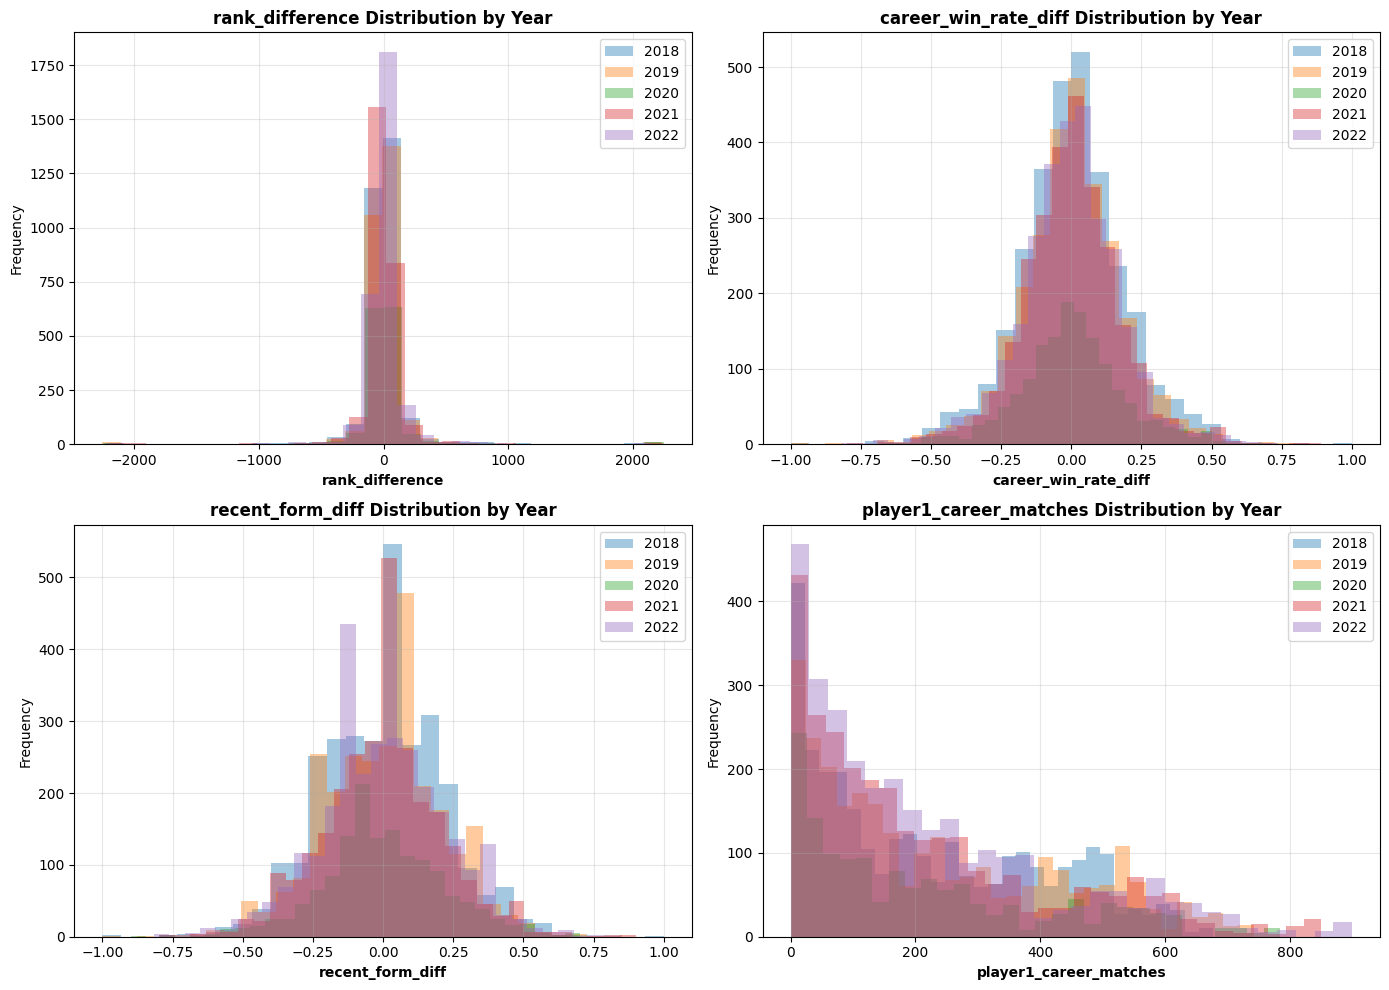


If means/stds are similar across years → K-Fold is safer
If means/stds shift significantly → Time-based validation is necessary


In [149]:
# ============================================================================
# EXPERIMENT: K-Fold vs Time-Based Validation
# ============================================================================

from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

print("="*70)
print("COMPARING K-FOLD VS TIME-BASED VALIDATION")
print("="*70)

# Your baseline model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# ============================================================================
# METHOD 1: K-Fold CV (What you're questioning)
# ============================================================================

print("\n📊 METHOD 1: K-Fold Cross-Validation (5-Fold)")
print("-" * 70)

# Combine train+val for K-Fold
X_train_val_combined = pd.concat([X_train, X_val])
y_train_val_combined = pd.concat([y_train, y_val])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = cross_val_score(
    rf_model, 
    X_train_val_combined, 
    y_train_val_combined, 
    cv=kfold, 
    scoring='accuracy',
    n_jobs=-1
)

print(f"K-Fold CV scores: {kfold_scores}")
print(f"Mean CV score: {kfold_scores.mean():.4f} ± {kfold_scores.std():.4f}")

# Now train on all train+val and test on 2024
rf_model.fit(X_train_val_combined, y_train_val_combined)
kfold_test_acc = accuracy_score(y_test, rf_model.predict(X_test))
print(f"Test score (2024): {kfold_test_acc:.4f}")

# ============================================================================
# METHOD 2: Time-Based Validation (Proper way)
# ============================================================================

print("\n📊 METHOD 2: Time-Based Validation (2018-2022 train, 2023 val)")
print("-" * 70)

# Train on 2018-2022 only
rf_model_time = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
rf_model_time.fit(X_train, y_train)

# Validate on 2023
time_val_acc = accuracy_score(y_val, rf_model_time.predict(X_val))
print(f"Validation score (2023): {time_val_acc:.4f}")

# Now retrain on train+val and test on 2024
rf_model_time.fit(X_train_val_combined, y_train_val_combined)
time_test_acc = accuracy_score(y_test, rf_model_time.predict(X_test))
print(f"Test score (2024): {time_test_acc:.4f}")

# ============================================================================
# COMPARISON
# ============================================================================

print("\n" + "="*70)
print("📊 COMPARISON RESULTS")
print("="*70)

print(f"\nK-Fold CV:        {kfold_scores.mean():.4f} ± {kfold_scores.std():.4f}")
print(f"Time-Based Val:   {time_val_acc:.4f}")

cv_gap = kfold_scores.mean() - time_val_acc
print(f"\nDifference: {cv_gap:+.4f} ({cv_gap*100:+.2f}%)")

if abs(cv_gap) < 0.005:  # Less than 0.5% difference
    print("\n✅ MINIMAL DIFFERENCE - K-Fold is probably fine!")
    print("   Your point is valid: temporal leakage is negligible.")
elif abs(cv_gap) < 0.015:  # Less than 1.5% difference
    print("\n⚠️  SMALL DIFFERENCE - K-Fold slightly optimistic")
    print("   Some temporal leakage, but not severe.")
else:  # More than 1.5% difference
    print("\n❌ SIGNIFICANT DIFFERENCE - K-Fold is too optimistic!")
    print("   Clear temporal leakage. Use time-based validation.")

print(f"\nTest scores (2024):")
print(f"  K-Fold method:     {kfold_test_acc:.4f}")
print(f"  Time-based method: {time_test_acc:.4f}")
print(f"  Difference:        {(kfold_test_acc - time_test_acc):+.4f}")

print("="*70)

# ============================================================================
# ADDITIONAL ANALYSIS: Feature Distributions Over Time
# ============================================================================

print("\n" + "="*70)
print("📈 FEATURE DISTRIBUTION ANALYSIS (Do features shift over time?)")
print("="*70)

# Check if key features have different distributions across years
import matplotlib.pyplot as plt

# Add year back temporarily for analysis
train_df_with_year = df[(df['tourney_date'] >= 20180000) & 
                         (df['tourney_date'] < 20230000)].copy()
train_df_with_year['year'] = train_df_with_year['tourney_date'] // 10000

# Key features to check
features_to_check = [
    'rank_difference',
    'career_win_rate_diff', 
    'recent_form_diff',
    'player1_career_matches'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_check):
    ax = axes[idx]
    
    # Plot distribution per year
    for year in sorted(train_df_with_year['year'].unique()):
        year_data = train_df_with_year[train_df_with_year['year'] == year][feature]
        ax.hist(year_data, bins=30, alpha=0.4, label=str(year))
    
    ax.set_xlabel(feature, fontweight='bold')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature} Distribution by Year', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Print statistics
    print(f"\n{feature}:")
    for year in sorted(train_df_with_year['year'].unique()):
        year_data = train_df_with_year[train_df_with_year['year'] == year][feature]
        print(f"  {year}: mean={year_data.mean():.3f}, std={year_data.std():.3f}")

plt.tight_layout()
plt.show()

print("\nIf means/stds are similar across years → K-Fold is safer")
print("If means/stds shift significantly → Time-based validation is necessary")
print("="*70)

## Applying PCA ( Not improving - To be expected )

In [150]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # After your train/val/test split

# # 1. Standardize (MANDATORY for PCA!)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)

# # 2. Apply PCA
# pca = PCA(n_components=0.80)  # Keep 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_val_pca = pca.transform(X_val_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# print(f"Reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} features")
# print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# # # 3. Train models on PCA features

# # ============================================================================
# # STEP 4: Train All Models (WITH PCA)
# # ============================================================================
# # ============================================================================
# # STEP 4: Train All Models (WITH PCA - Same Variable Names)
# # ============================================================================

# print("="*70)
# print("TRAINING ALL MODELS WITH PCA FEATURES")
# print("="*70)

# # 1. Decision Tree (using PCA features)
# print("\n1. Training Decision Tree...")
# dt_model = DecisionTreeClassifier(
#     max_depth=10,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     random_state=42
# )
# dt_model.fit(X_train_pca, y_train)

# dt_y_train_pred = dt_model.predict(X_train_pca)
# dt_y_val_pred = dt_model.predict(X_val_pca)
# dt_y_test_pred = dt_model.predict(X_test_pca)
# print("   ✓ Decision Tree trained!")

# # 2. Random Forest (using PCA features)
# print("\n2. Training Random Forest...")
# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=10,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     random_state=42
# )
# rf_model.fit(X_train_pca, y_train)

# rf_y_train_pred = rf_model.predict(X_train_pca)
# rf_y_val_pred = rf_model.predict(X_val_pca)
# rf_y_test_pred = rf_model.predict(X_test_pca)
# print("   ✓ Random Forest trained!")

# # 3. Logistic Regression (using PCA features - already scaled!)
# print("\n3. Training Logistic Regression...")
# lr_model = LogisticRegression(
#     max_iter=1000,
#     random_state=42
# )
# lr_model.fit(X_train_pca, y_train)

# lr_y_train_pred = lr_model.predict(X_train_pca)
# lr_y_val_pred = lr_model.predict(X_val_pca)
# lr_y_test_pred = lr_model.predict(X_test_pca)
# print("   ✓ Logistic Regression trained!")

# # 4. XGBoost (using PCA features)
# print("\n4. Training XGBoost...")
# xgb_model = XGBClassifier(
#     n_estimators=200,
#     max_depth=8,
#     learning_rate=0.1,
#     subsample=0.58,
#     colsample_bytree=0.8,
#     random_state=42,
#     eval_metric='logloss',
#     use_label_encoder=False
# )
# xgb_model.fit(X_train_pca, y_train)

# xgb_y_train_pred = xgb_model.predict(X_train_pca)
# xgb_y_val_pred = xgb_model.predict(X_val_pca)
# xgb_y_test_pred = xgb_model.predict(X_test_pca)
# print("   ✓ XGBoost trained!")

# print("\n" + "="*70)
# print("ALL MODELS TRAINED SUCCESSFULLY WITH PCA")
# print(f"Features: {X_train_pca.shape[1]} principal components")
# print("="*70)

# Training All models for Non PCA features

In [151]:
# ============================================================================
# STEP 4: Train All Models
# ============================================================================

print("="*70)
print("TRAINING ALL MODELS")
print("="*70)

# 1. Decision Tree
print("\n1. Training Decision Tree...")
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
dt_model.fit(X_train, y_train)

dt_y_train_pred = dt_model.predict(X_train)
dt_y_val_pred = dt_model.predict(X_val)
dt_y_test_pred = dt_model.predict(X_test)
print("   ✓ Decision Tree trained!")


# Implemented with RandomSearchCV - Hyper parameters ( but somehow my original baseline model is better LOL)
# 2. Random Forest
print("\n2. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    # max_features=None,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train)

rf_y_train_pred = rf_model.predict(X_train)
rf_y_val_pred = rf_model.predict(X_val)
rf_y_test_pred = rf_model.predict(X_test)
print("   ✓ Random Forest trained!")

# 3. Logistic Regression (needs scaling)
print("\n3. Training Logistic Regression...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_scaled, y_train)

lr_y_train_pred = lr_model.predict(X_train_scaled)
lr_y_val_pred = lr_model.predict(X_val_scaled)
lr_y_test_pred = lr_model.predict(X_test_scaled)
print("   ✓ Logistic Regression trained!")

# 4. XGBoost
print("\n4. Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.58,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train)

xgb_y_train_pred = xgb_model.predict(X_train)
xgb_y_val_pred = xgb_model.predict(X_val)
xgb_y_test_pred = xgb_model.predict(X_test)
print("   ✓ XGBoost trained!")

print("\n" + "="*70)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*70)

TRAINING ALL MODELS

1. Training Decision Tree...
   ✓ Decision Tree trained!

2. Training Random Forest...
   ✓ Random Forest trained!

3. Training Logistic Regression...
   ✓ Logistic Regression trained!

4. Training XGBoost...
   ✓ XGBoost trained!

ALL MODELS TRAINED SUCCESSFULLY


In [ ]:
# ============================================================================
# STEP 5: Evaluate All Models Individually
# ============================================================================

def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display evaluation metrics"""
    # these functions are imported from sklearn.metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # print(f"{dataset_name:15s}: Acc={accuracy:.4f} | Prec={precision:.4f} | Rec={recall:.4f} | F1={f1:.4f}")
    return accuracy, precision, recall, f1

# Store all models and predictions
models = {
    'Decision Tree': (dt_y_train_pred, dt_y_val_pred, dt_y_test_pred),
    'Random Forest': (rf_y_train_pred, rf_y_val_pred, rf_y_test_pred),
    'Logistic Reg':  (lr_y_train_pred, lr_y_val_pred, lr_y_test_pred),
    'XGBoost':       (xgb_y_train_pred, xgb_y_val_pred, xgb_y_test_pred)
}

# Evaluate all models
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)

results = {}
for model_name, (train_pred, val_pred, test_pred) in models.items():
    print(f"\n{model_name}:")
    print("-" * 70)
    
    train_metrics = evaluate_model(y_train, train_pred, "  Train")
    val_metrics = evaluate_model(y_val, val_pred, "  Validation")
    test_metrics = evaluate_model(y_test, test_pred, "  Test")
    
    # Check overfitting
    train_val_gap = (train_metrics[0] - val_metrics[0]) * 100
    train_test_gap = (train_metrics[0] - test_metrics[0]) * 100
    
    # print(f"  Overfit gap:   Train-Val={train_val_gap:+.2f}% | Train-Test={train_test_gap:+.2f}%")
    
    # Store results
    results[model_name] = {
        'train_acc': train_metrics[0],
        'val_acc': val_metrics[0],
        'test_acc': test_metrics[0],
        'train_val_gap': train_val_gap,
        'train_test_gap': train_test_gap
    }

# Summary comparison
print("\n" + "="*70)
print("SUMMARY: TEST ACCURACY RANKING")
print("="*70)
sorted_models = sorted(results.items(), key=lambda x: x[1]['test_acc'], reverse=True)

for i, (model_name, metrics) in enumerate(sorted_models, 1):
    print(f"{i}. {model_name:15s}: {metrics['test_acc']:.4f} ({metrics['test_acc']*100:.2f}%)")

# Best model
best_model = sorted_models[0][0]
print(f"\n🏆 Best Model: {best_model} with {sorted_models[0][1]['test_acc']*100:.2f}% test accuracy")


MODEL PERFORMANCE COMPARISON

Decision Tree:
----------------------------------------------------------------------

Random Forest:
----------------------------------------------------------------------

Logistic Reg:
----------------------------------------------------------------------

XGBoost:
----------------------------------------------------------------------

SUMMARY: TEST ACCURACY RANKING
1. Random Forest  : 0.6558 (65.58%)
2. Logistic Reg   : 0.6513 (65.13%)
3. XGBoost        : 0.6356 (63.56%)
4. Decision Tree  : 0.6106 (61.06%)

🏆 Best Model: Random Forest with 65.58% test accuracy



TOP 20 MOST IMPORTANT FEATURES
                feature  importance
        rank_difference    0.294754
   career_win_rate_diff    0.098486
         age_difference    0.061578
player1_career_win_rate    0.038994
           player1_rank    0.036768
           player2_rank    0.034842
            player1_age    0.027909
 player1_career_matches    0.026845
  player1_hard_win_rate    0.024760
    player1_career_wins    0.024561
     hard_win_rate_diff    0.022563
            player2_age    0.019454
             player2_ht    0.019217
player2_career_win_rate    0.018712
    player2_career_wins    0.016254
             player1_ht    0.015010
     clay_win_rate_diff    0.013722
       recent_form_diff    0.013583
      height_difference    0.013549
  player2_hard_win_rate    0.010998


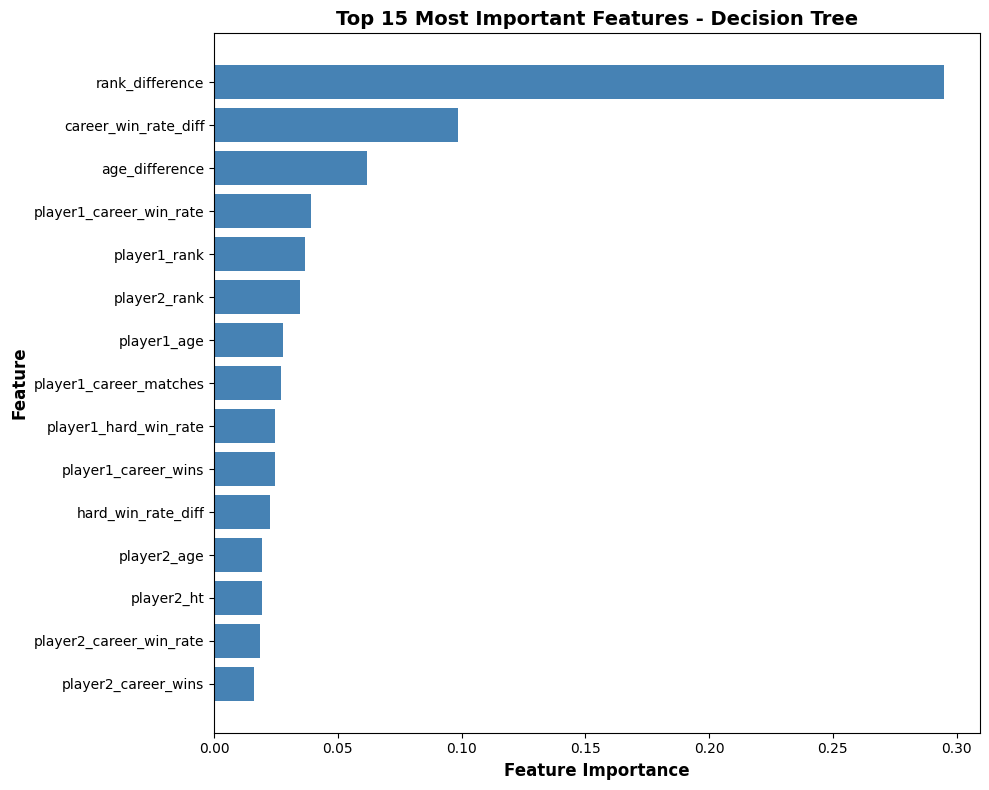


✓ Feature importance saved to '../results/baseline_dt_feature_importance.csv'


In [153]:
# ============================================================================
# STEP 7: Feature Importance Analysis
# ============================================================================

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save feature importance to CSV
feature_importance.to_csv('../results/baseline_dt_feature_importance.csv', index=False)
print("\n✓ Feature importance saved to '../results/baseline_dt_feature_importance.csv'")


# Trying Ensembles 